## Imports

In [68]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping

In [8]:
import pandas as pd

# Setting seed & importing data

In [21]:
tf.random.set_seed(8)

df = pd.read_csv('data/original_data.csv')
df.head()

,headline,label
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [15]:
df.isna().sum()

headline    0
label       0
dtype: int64

In [20]:
df.shape

<class 'KeyError'>: 1

## Splitting data

In [23]:
X = df["headline"]
y = df["label"]

splitting data 70\% train, 10\% validation, 20\% test

In [28]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=28)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=28)

In [32]:
X_train.sample(4)

20506    bill o'reilly's advertisers can't keep looking...
17102    this will make you never want to check a bag a...
18284    romney takes in more money than obama for 612t...
11399    inside cbs' bid to bolster 'late show with ste...
Name: headline, dtype: object

## Tokenization and padding

In [44]:
# tokenizing:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# padding:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

max_length = max(len(sequence) for sequence in sequences_train)

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding='post')
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')


print(padded_train[0:3])
print(max_length)

[[ 2689   351     2 12262   159  4620     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [ 2285   422     3 12263  1336  8496 12264   804   667  3246     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [ 4028  2286   718    21    17    32  3597     5   976   327   352     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]
38


## Embedding

In [73]:
# Early stopping:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [74]:
vocab_size = len(word_index) + 1
embed_dim = 16

model_relu = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout layer added
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_relu.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model_relu.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 38, 16)            397472    
                                                                 
 global_average_pooling1d_7  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_14 (Dense)            (None, 24)                408       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                                                                 
Total params: 397905 (1.52 MB)
Trainable params: 397905 (1.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

## Training

In [75]:
num_epochs = 10

history_relu = model_relu.fit(padded_train, y_train, epochs=num_epochs, validation_data=(padded_val, y_val), verbose=2, callbacks=early_stopping)

Epoch 1/10
585/585 - 3s - loss: 0.6428 - accuracy: 0.6318 - val_loss: 0.4929 - val_accuracy: 0.8094 - 3s/epoch - 5ms/step
Epoch 2/10
585/585 - 2s - loss: 0.3883 - accuracy: 0.8449 - val_loss: 0.3520 - val_accuracy: 0.8487 - 2s/epoch - 4ms/step
Epoch 3/10
585/585 - 2s - loss: 0.2684 - accuracy: 0.8996 - val_loss: 0.3265 - val_accuracy: 0.8612 - 2s/epoch - 4ms/step
Epoch 4/10
585/585 - 3s - loss: 0.1989 - accuracy: 0.9312 - val_loss: 0.3259 - val_accuracy: 0.8620 - 3s/epoch - 4ms/step
Epoch 5/10
585/585 - 3s - loss: 0.1504 - accuracy: 0.9521 - val_loss: 0.3393 - val_accuracy: 0.8616 - 3s/epoch - 5ms/step
Epoch 6/10
Restoring model weights from the end of the best epoch: 4.
585/585 - 2s - loss: 0.1145 - accuracy: 0.9660 - val_loss: 0.3625 - val_accuracy: 0.8623 - 2s/epoch - 4ms/step
Epoch 6: early stopping


## Plotting curves

In [58]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

C:/Users/olivi/AppData/Local/Temp/xpython_31672/2336864335.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


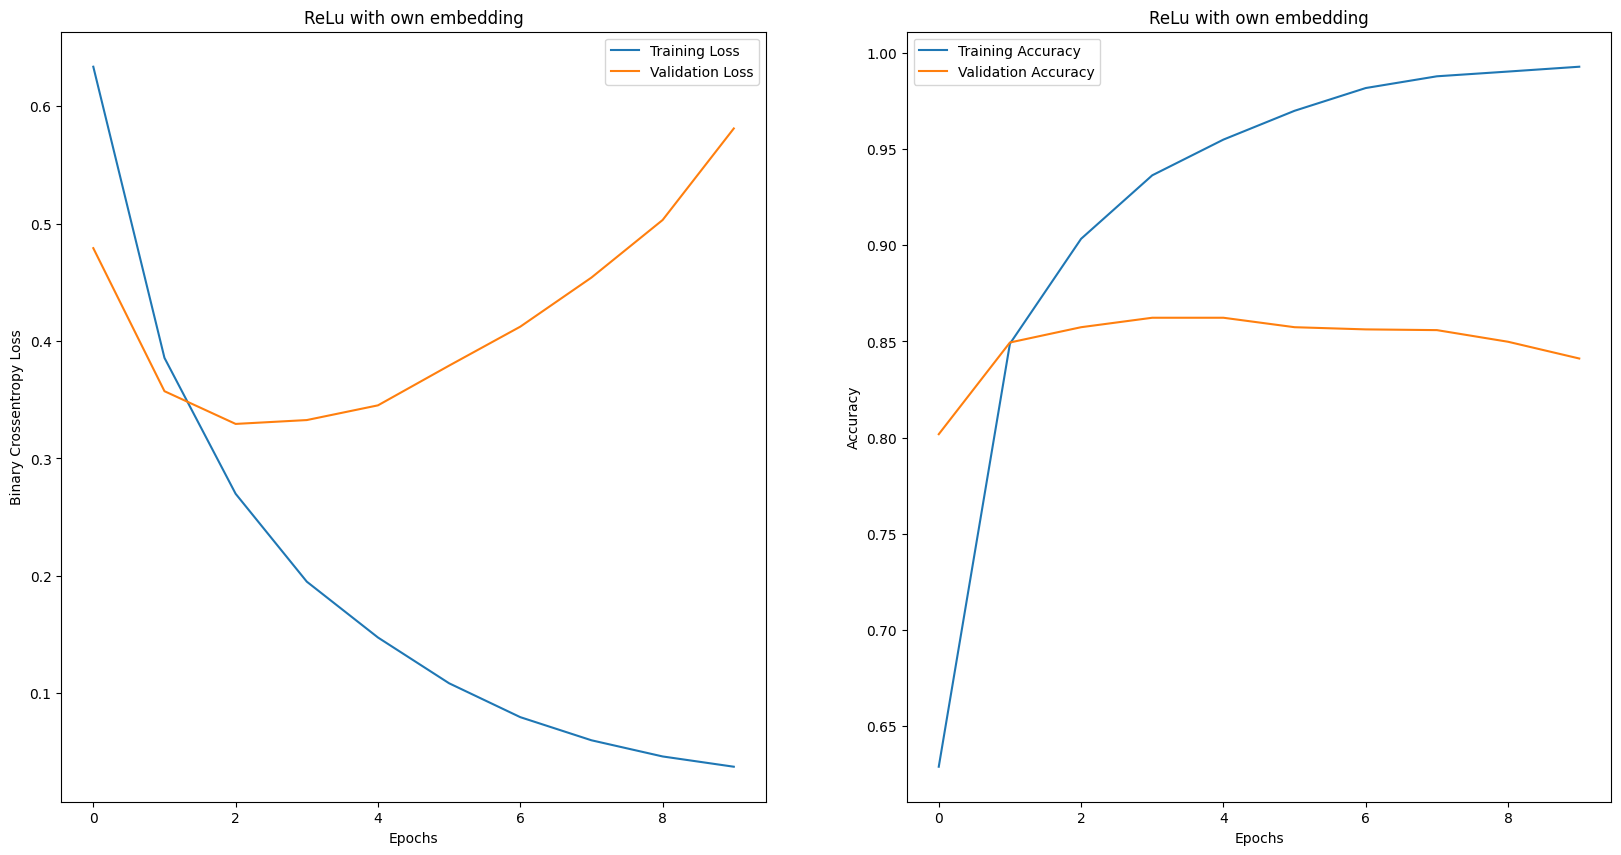

In [67]:
## ReLu with own embedding
plotCurves(history_relu, "ReLu with own embedding")